In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 제출 파일 생성 관련
import os
import zipfile

# 데이터 처리 및 분석
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm

import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

# To ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# 데이터 불러오기
path = '/content/drive/MyDrive/Colab Notebooks/fsi/open/'

train_all = pd.read_csv(path + "train.csv")
test_all = pd.read_csv(path + "test.csv")

train = train_all.drop(columns="ID")

# FIN - 30개 고정

In [8]:
import pandas as pd

# IQR을 이용한 이상치 처리 함수 정의
def replace_outliers_with_median(df, group_column, target_column):
    def replace_outliers(group):
        Q1 = group[target_column].quantile(0.25)
        Q3 = group[target_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 중앙값 계산
        median_value = group[target_column].median()

        # 이상치를 중앙값으로 대체
        group[target_column] = group[target_column].apply(
            lambda x: median_value if x < lower_bound or x > upper_bound else x
        )

        return group

    # 그룹별로 함수 적용
    df_cleaned = df.groupby(group_column, group_keys=False).apply(replace_outliers).reset_index(drop=True)

    return df_cleaned

In [9]:
# Time_difference 컬럼을 총 초로 변환 및 이상치 처리
timedeltas = pd.to_timedelta(train.Time_difference)
average_time = timedeltas.mean()
average_time_formatted = str(pd.to_timedelta(average_time)).split('.')[0]
train.loc[13972, 'Time_difference'] = average_time_formatted

train['Time_difference_seconds'] = pd.to_timedelta(train['Time_difference']).dt.total_seconds()


# account 관련 값들 이상치 처리하기
for x in ['Account_initial_balance', 'Account_balance', 'Account_remaining_amount_daily_limit_exceeded',
          'Account_one_month_max_amount', 'Account_one_month_std_dev', 'Account_dawn_one_month_max_amount', 'Time_difference_seconds',
          'Account_dawn_one_month_std_dev']:
    train = replace_outliers_with_median(train, 'Fraud_Type', x)


120000 30


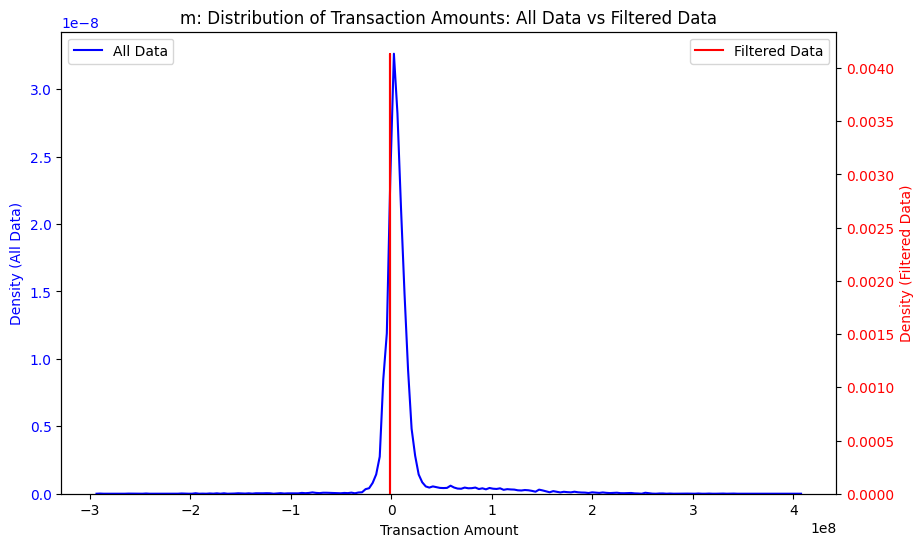

120000 30


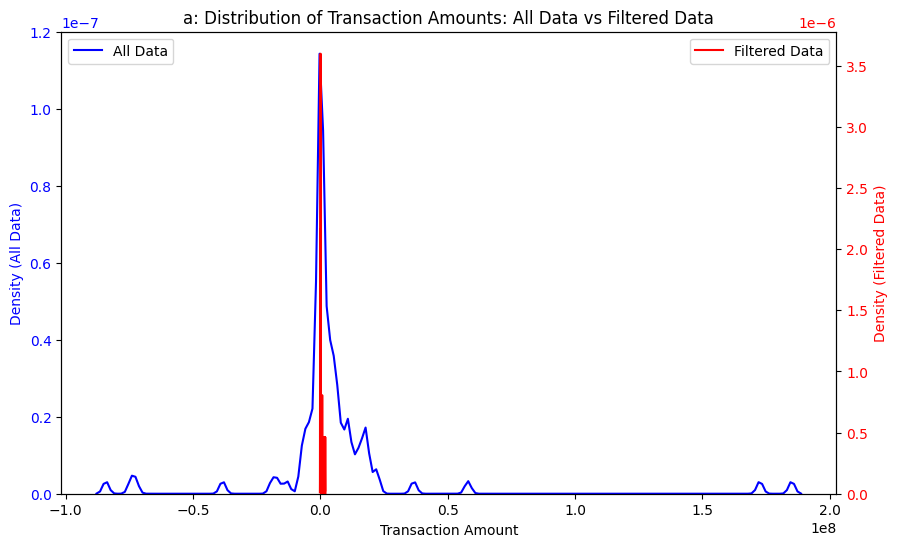

120000 30


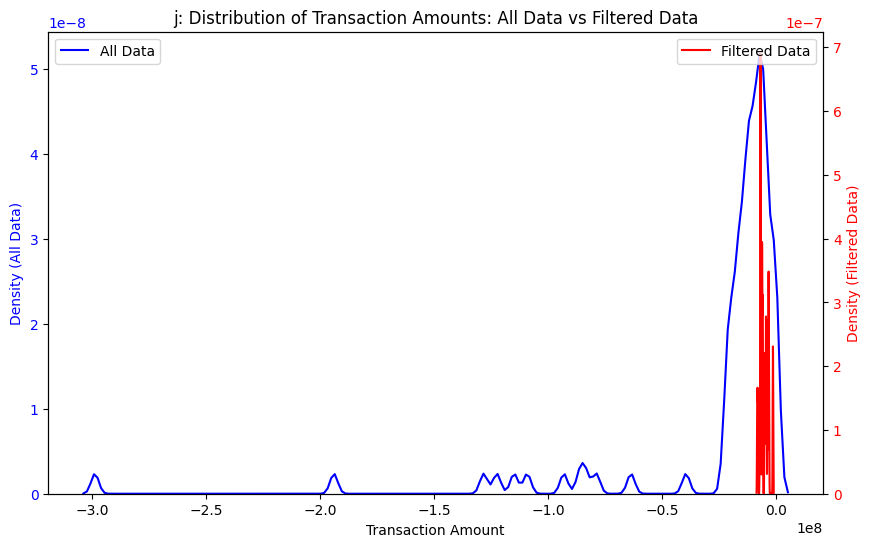

120000 30


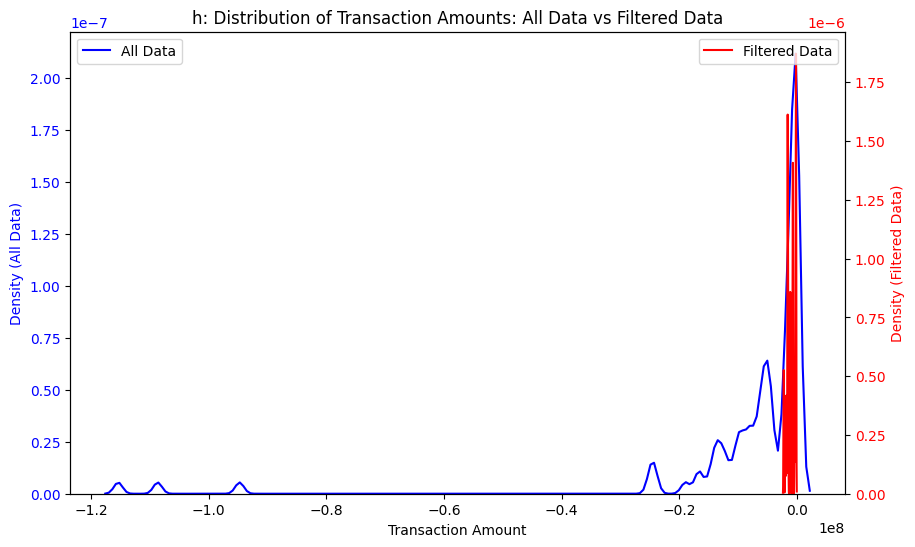

120000 30


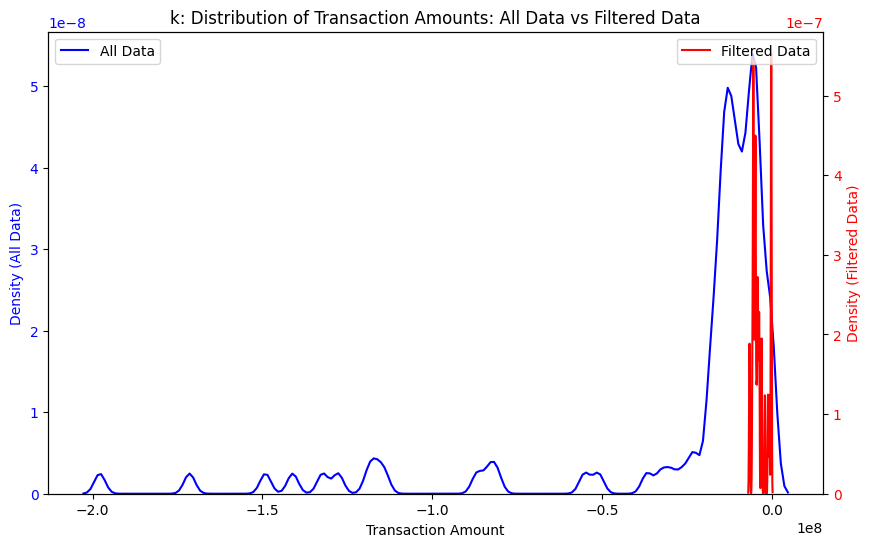

120000 30


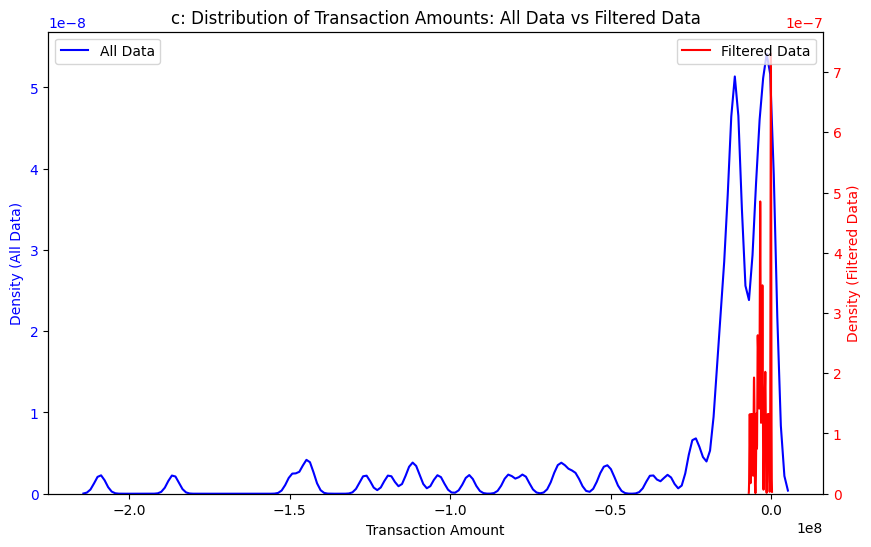

120000 30


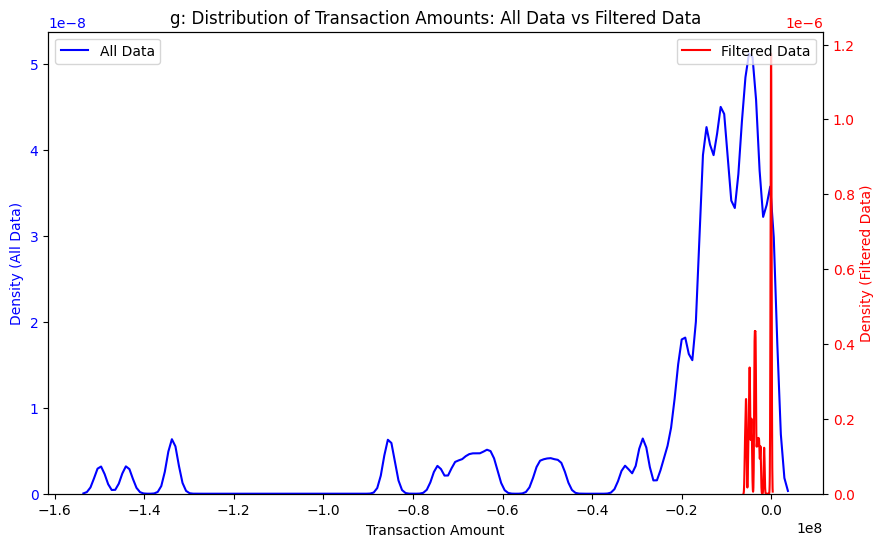

120000 30


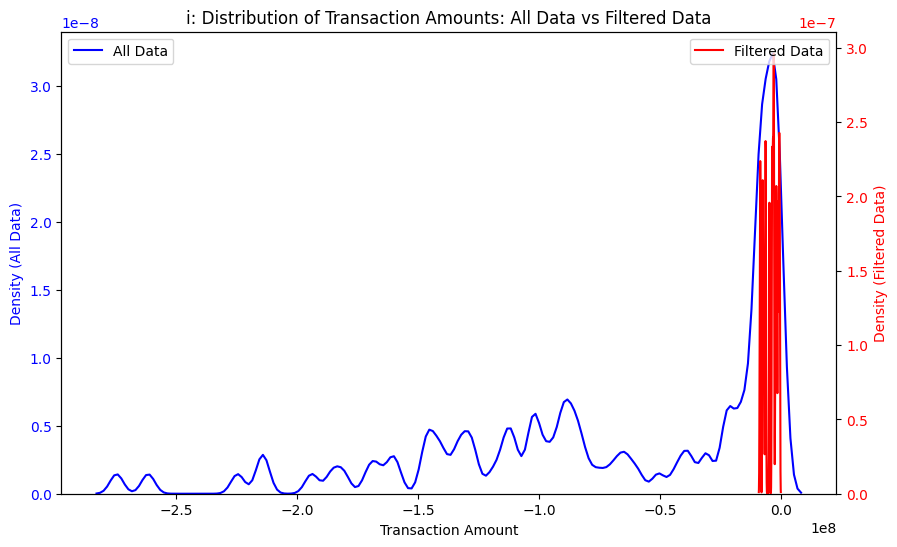

120000 30


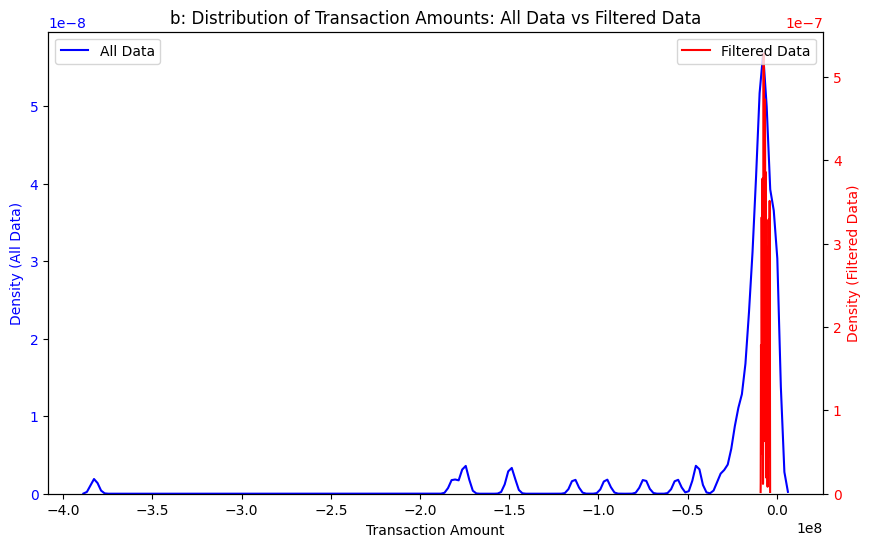

120000 30


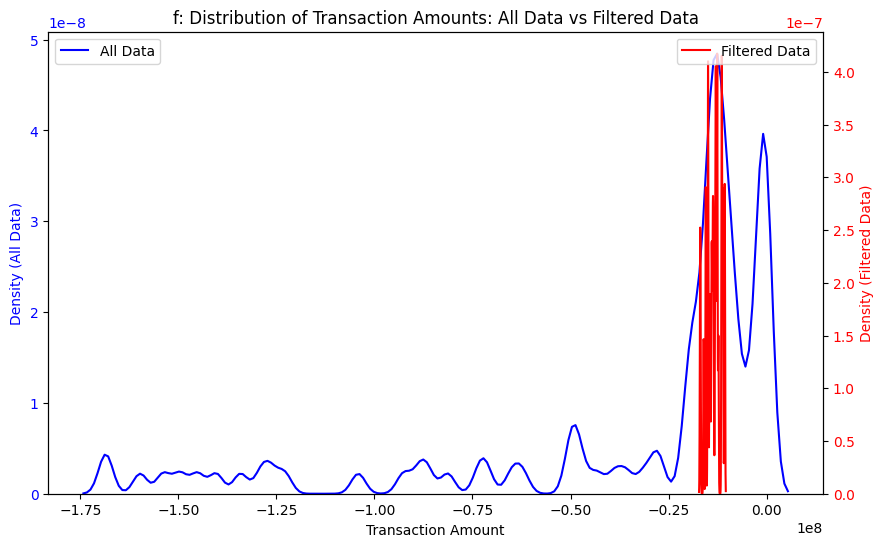

120000 30


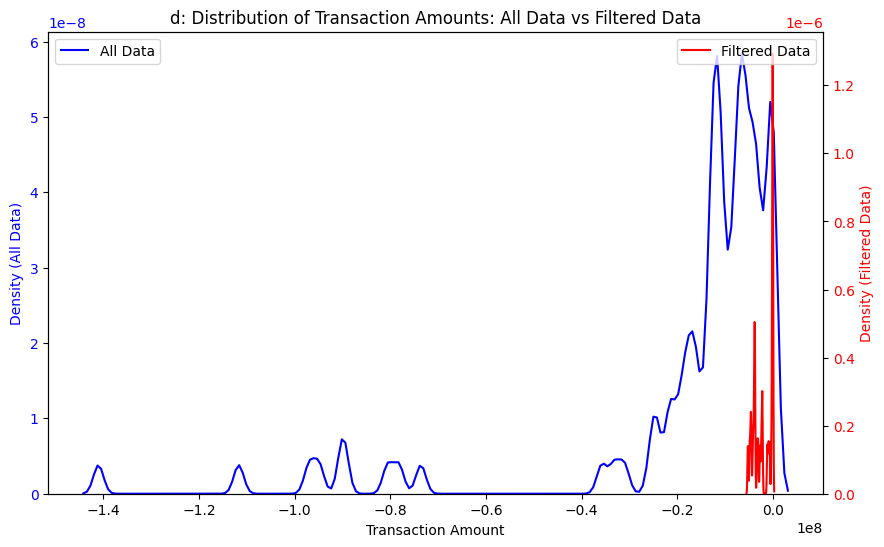

120000 30


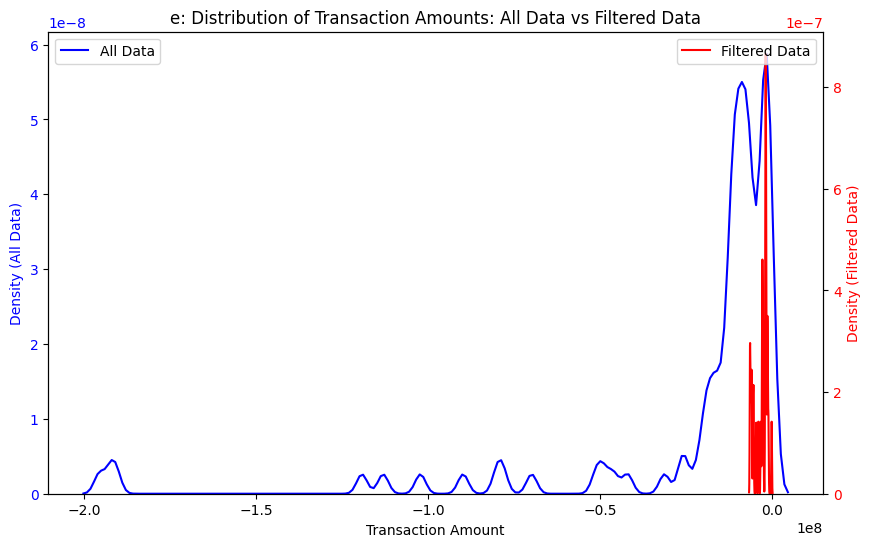

120000 30


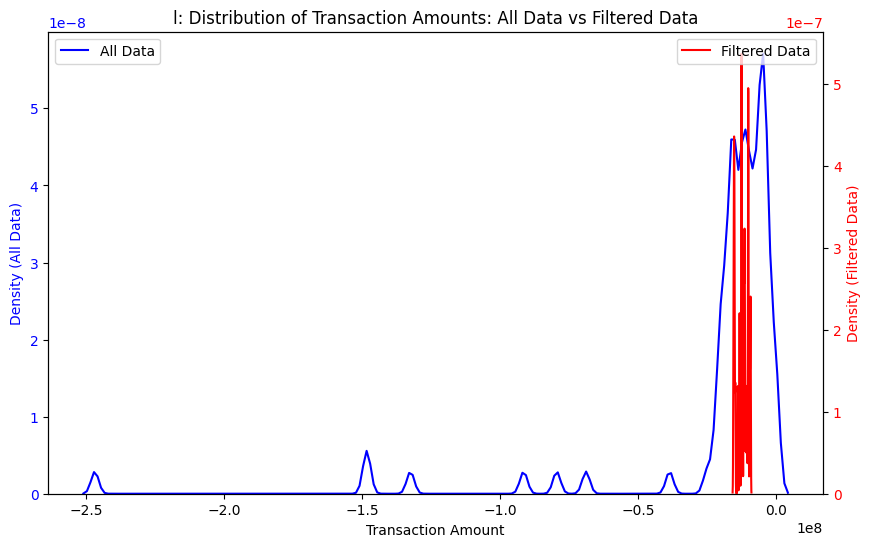

In [10]:

# 모든 합성 데이터를 저장할 DataFrame 초기화
pre_synthetic_data = pd.DataFrame()


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ft_list = train_all.Fraud_Type.unique()

for x in ft_list:
    # Step 1: 전체 데이터에서 가장 많은 지점(모드) 찾기
    counts, bin_edges = np.histogram(
        train[train['Fraud_Type'] == x].Transaction_Amount, bins=30)

    # 가장 빈도가 높은 bin의 중간값을 찾기
    max_count_idx = np.argmax(counts)
    mode_value = (bin_edges[max_count_idx] + bin_edges[max_count_idx + 1]) / 2

    # Step 2: 모드값을 기준으로 데이터 정렬
    sorted_data = train[train['Fraud_Type'] == x].copy()
    sorted_data['distance_to_mode'] = np.abs(sorted_data['Transaction_Amount'] - mode_value)
    sorted_data = sorted_data.sort_values(by='distance_to_mode')

    # Step 3: 모드값에서 가장 가까운 앞뒤 30개의 데이터 포인트 선택
    filtered_data = sorted_data.head(30)

    print(len(train), len(filtered_data))

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Figure 및 첫 번째 Y축 생성
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 전체 데이터의 KDE 플롯 (왼쪽 Y축 사용)
    sns.kdeplot(
        train[train['Fraud_Type'] == x].Transaction_Amount,
        color='blue', ax=ax1, bw_adjust=0.1, label='All Data'
    )

    # 첫 번째 Y축 레이블
    ax1.set_ylabel('Density (All Data)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # 두 번째 Y축 생성 및 설정
    ax2 = ax1.twinx()
    sns.kdeplot(
        filtered_data.Transaction_Amount,
        color='red', ax=ax2, bw_adjust=0.1, label='Filtered Data'
    )

    # 두 번째 Y축 레이블
    ax2.set_ylabel('Density (Filtered Data)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # X축 레이블과 타이틀 설정
    ax1.set_xlabel('Transaction Amount')
    plt.title(x + ': Distribution of Transaction Amounts: All Data vs Filtered Data')

    # 범례 설정
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 플롯 보여주기
    plt.show()

    # 생성된 데이터를 all_synthetic_data에 추가
    pre_synthetic_data = pd.concat([pre_synthetic_data, filtered_data], ignore_index=True)


In [11]:
# 불필요한 칼럼 드랍
pre_synthetic_data.drop('distance_to_mode', axis=1, inplace=True)

In [12]:
# 저장
save_path = '/content/drive/MyDrive/Colab Notebooks/fsi/processed_data'
pre_synthetic_data.to_csv(save_path + '/1_30_sample_pre_syn.csv', index=False)

In [13]:
tmp = pd.read_csv(save_path + '/1_30_sample_pre_syn.csv')
tmp.Fraud_Type.value_counts()

,count
Fraud_Type,
m,30
a,30
j,30
h,30
k,30
c,30
g,30
i,30
b,30


In [14]:
pre_synthetic_data

,Customer_Birthyear,Customer_Gender,Customer_personal_identifier,Customer_identification_number,Customer_registration_datetime,Customer_credit_rating,Customer_flag_change_of_authentication_1,Customer_flag_change_of_authentication_2,Customer_flag_change_of_authentication_3,Customer_flag_change_of_authentication_4,...,Last_bank_branch_transaction_datetime,Flag_deposit_more_than_tenMillion,Unused_account_status,Recipient_account_suspend_status,Number_of_transaction_with_the_account,Transaction_history_with_the_account,First_time_iOS_by_vulnerable_user,Fraud_Type,Transaction_resumed_date,Time_difference_seconds
0,1975,male,김정수,bOmGVU-wftnubo,2008-05-26 04:44:27,B,1,1,1,1,...,2012-01-09 15:10:28,0,0,1,1,3,0,m,2011-10-14 03:18:27,10558.0
1,1952,female,김지혜,eFVRTS-AVwOBPh,2009-04-21 17:51:13,C,1,1,1,1,...,2014-09-29 09:35:28,1,0,0,4,4,0,m,2014-09-22 16:57:35,6771.0
2,1964,female,류민지,xlasgS-atOTnhB,2009-02-07 20:29:36,B,1,1,0,1,...,2016-10-24 20:03:41,1,1,0,0,0,0,m,2016-10-22 18:17:08,6434.0
3,1982,female,최선영,wBfgfq-OQAhBRG,2010-07-07 21:43:21,E,0,0,0,1,...,2023-12-24 05:48:25,0,1,0,0,0,0,m,2025-01-09 21:58:28,440773.0
4,1962,female,박경희,IiXLqV-LLRKgWN,2012-02-27 22:19:41,A,1,1,1,1,...,2032-09-11 21:39:04,1,1,0,0,0,0,m,2032-07-11 19:55:30,4303.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,1951,male,김준호,ThIwhe-qVjCwaT,2003-04-05 06:32:16,D,1,1,1,0,...,2019-02-08 18:03:10,0,1,0,0,0,0,l,2019-02-08 14:15:36,530710.0
386,1959,male,김상훈,xEGhiW-DcmZHMu,2003-12-19 18:12:29,D,1,1,1,1,...,2030-10-16 09:02:07,1,0,1,1,1,0,l,2030-09-24 02:44:15,2813.0
387,1950,female,이수빈,CydnTW-PxvvTxW,2008-12-22 03:44:43,C,1,1,1,1,...,2023-11-22 05:01:12,0,1,0,0,0,0,l,2023-10-31 04:05:27,330564.0
388,1954,female,이지우,NdNXIW-VguSsgF,2004-12-29 15:14:46,C,1,1,0,1,...,2020-07-10 01:08:41,0,0,1,1,1,0,l,2020-07-10 01:08:41,8381.0
